## Parallel case

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import _lib.pr_func as pr
from _lib.utility import *
%config InlineBackend.figure_format = 'retina'
sns.set()

In [25]:
# dimensions
N,M,K = 20,5,20
pr.set_dims([('w',N),('x',M),('a',K)])

# environment
U = pr.func(vars=['w','a'],val=gauss_utility(N,K,sigma=2.0))
pw = pr.func(vars=['w'],val='unif').normalize()

# Lagrange multipliers
beta1  = 100.0                               # first step, p(x) -> p(x|w)
beta2 = 10.0*pr.func(vars=['x'],val='unif') # second step, p(a|x) -> p(a|x,w);
# different beta2s for each agent labelled by 'x' can be set by 
# beta2 = pr.func(vars=['x'], val=np.array([...])), or beta2.val = np.array([...]) (must have a length of M) 

In [26]:
# initializations
px = pr.func(vars=['x'], val='unif').normalize()
pagx = pr.func(vars=['a','x'], val='unif').normalize(['a'])
F = pr.func('f(w,x)', val='rnd')
pagxw_temp = 0

# BA iteration
for i in range(0,10000):
    pxgw = (px*pr.exp(beta2*F)).normalize(['x'])
    px = pr.sum(pw*pxgw,['w'])
    pagxw = (pagx*pr.exp(beta2*U)).normalize(['a'])
    pagx = pr.sum(pw*pxgw*pagxw,['w'])/px
    F = pr.sum(pagxw*(U-pr.log(pagxw/pagx)/beta2),['a'])
    
    # stopping condition
    if np.linalg.norm(pagxw.val-pagxw_temp)<1e-10: break
    pagxw_temp = pagxw.val

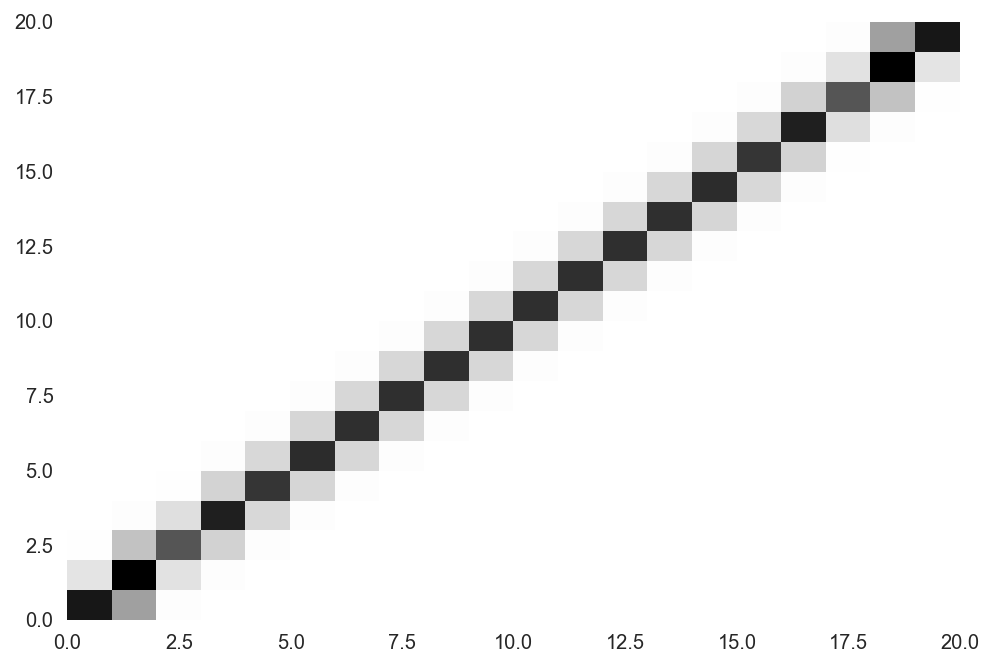

DKL1 = 0.439, DKL2 = 2.427, EU = 0.947, FE = 0.775


In [27]:
# calc and plot p(a|w)
pagw = pr.sum(pxgw*pagxw,['x'])
plt.pcolor(pagw.val,cmap="Greys")
plt.show()

# calc and print stats
DKL1 = pr.sum(pw*pxgw*pr.log(pxgw/px)).val/np.log(2)             # DKL of the coordinating agent 
DKL2_x = pr.sum(pw*pxgw*pagxw*pr.log(pagxw/pagx)/px, ['a','w'])  # DKL2 as a function of x
DKL2 = pr.sum(px*DKL2_x).val/np.log(2)                           # DKL2 averaged over all agents in the second step
EU = pr.sum(pw*pagw*U).val                                       # expected utility
FE = (EU - DKL1/beta1 - pr.sum(px*(DKL2_x/beta2))).val           # free energy
print "DKL1 = {:.3f}, DKL2 = {:.3f}, EU = {:.3f}, FE = {:.3f}".format(DKL1,DKL2,EU,FE)